In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Add
from keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.datasets import mnist, fashion_mnist
import tensorflow_datasets as tfds

import numpy as np
from matplotlib import pyplot as plt
import random
import json

# Blind source separation

This project aims to separate an image, formed as the sum of two images, into its original components.

The two source images, img1 and img2, are drawn from different datasets: MNIST and Fashion-MNIST, respectively.

No preprocessing is allowed. The neural network receives the combined image (img1 + img2) as input and outputs the predicted components (hat_img1,hat_img2).

Performance is evaluated using the mean squared error (MSE) between the predicted and ground-truth images.

Both datasets (MNIST and Fashion-MNIST) are grayscale. For simplicity, all samples are padded to a (32,32) resolution.

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))

#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))

(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Let us define a generator with batchsize=1 and let's test it.

In [ ]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

In [ ]:
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

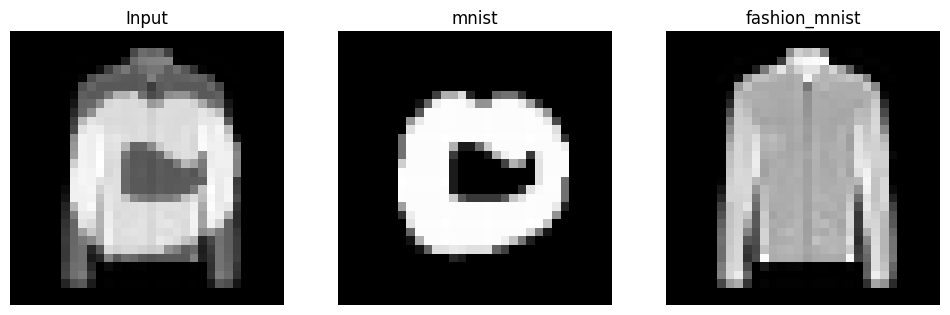

In [ ]:
x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])

# Model evalaution

Let us define the test generator.

In [ ]:
testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,5000)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

We test a model returning twice the input image. You will need to replace it with your own predictive model.

In [ ]:
def ide_model(x):
   return((x,x))

In [ ]:
def eval_model(model):
  x, (y1,y2) = next(testgen)

  # use model.predict to get predictions. Here we just call model
  pred1,pred2 = model(x)

  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)

In [ ]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(ide_model))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mse =  0.05458777708400914
standard deviation =  0.000264529111464916


# What to deliver
As usual, you are supposed to deliver a single notebook that is supposed to run on colab. The notebook should be adequately commented, contain a full trace of the training, the computation of the mse in the form specified above and a few examples.

Good Work!

# Configuration

## Utils

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

In [ ]:
def show_prediction(model):
  x,(y1,y2)=next(one_shot_testgen)
  pred1, pred2 = model.predict(x)

  plt.figure(figsize=(6,5))
  plt.subplot(3,2,1)
  plt.title('Mixture')
  plt.imshow(x[0], 'gray')
  plt.grid(False)

  plt.subplot(3,2,3)
  plt.title('Ground truth 1')
  plt.imshow(y1[0], 'gray')
  plt.grid(False)

  plt.subplot(3,2,4)
  plt.title('Ground truth 2')
  plt.imshow(y2[0], 'gray')
  plt.grid(False)

  plt.subplot(3,2,5)
  plt.title('Predicted 1')
  plt.imshow(pred1[0], 'gray')
  plt.grid(False)

  plt.subplot(3,2,6)
  plt.title('Predicted 2')
  plt.imshow(pred2[0], 'gray')
  plt.grid(False)

  plt.tight_layout()
  plt.show()

In [ ]:
def eval_model(model, testgen):
  x, (y1,y2) = next(testgen)

  # use model.predict to get predictions. Here we just call model
  pred1,pred2 = model(x)

  return (np.mean((pred1[:,:,:,0]-y1)**2) + np.mean((pred2[:,:,:,0]-y2)**2) / 2)

In [ ]:
def compute_statistics(model, testgen):
  repeat_eval = 10
  eval_results = []

  for i in range(repeat_eval):
    eval_results.append(eval_model(model, testgen))

  print("mse = ", np.mean(eval_results))
  print("standard deviation = ", np.std(eval_results))

## Setup

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.

(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
training_batch_size = 64
validation_batch_size = 64
test_batch_size = 1024

train_gen = datagenerator(mnist_x_test, fashion_mnist_x_test, training_batch_size)
validation_gen = datagenerator(mnist_x_test, fashion_mnist_x_test, validation_batch_size)
test_gen = datagenerator(mnist_x_test, fashion_mnist_x_test, test_batch_size)

one_shot_testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

We can push the model for a lot of epochs without the risk of overfitting since there are 60*10^8 different images in the training set.

In [ ]:
epochs = 500
steps_per_epoch = 100
lr = 1e-4

# A First Approach: Transfer Learning

As a first attempt one can try with transfer learning in order to extract features that derives from a consolidated knowledge of *what* an image is and then upsample these features in order to reconstruct the images (autoencoder-like). In the case of ResNet50 we end up with a final dimension of 1x1x2024 if we exclude the classification head, and then we have to upsample this dimension back to the input dimension of the image (i.e. 32x32x1).

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(32,32,3), weights='imagenet')
base_model.trainable = False  # Freeze feature extractor

inputs = Input(shape=(32,32,1))
x = Conv2D(3, (3,3), padding="same")(inputs)  # Convert grayscale to 3-channel
x = base_model(x)  # Extract features
x = layers.Conv2DTranspose(64, (3,3), activation="swish", padding="same")(x)
x = UpSampling2D((2,2))(x) #2x2

x = layers.Conv2DTranspose(64, (3,3), activation="swish", padding="same")(x)
x = UpSampling2D((2,2))(x) #4x4

x = layers.Conv2DTranspose(32, (3,3), activation="swish", padding="same")(x)
x = UpSampling2D((2,2))(x) #8x8

x = layers.Conv2DTranspose(32, (3,3), activation="swish", padding="same")(x)
x = UpSampling2D((2,2))(x) #16x16

x = layers.Conv2DTranspose(16, (3,3), activation="swish", padding="same")(x)
x = UpSampling2D((2,2))(x) #32x32

output1 = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)
output2 = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

transfer_model = Model(inputs, [output1, output2])
transfer_model.compile(optimizer=AdamW(lr), loss="mse")

In [ ]:
transfer_hist = transfer_model.fit(
    train_gen,
    epochs = epochs,
    validation_data = validation_gen,
    steps_per_epoch = steps_per_epoch,
    validation_steps = steps_per_epoch
)

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - conv2d_1_loss: 0.0748 - conv2d_2_loss: 0.0872 - loss: 0.1620 - val_conv2d_1_loss: 0.0530 - val_conv2d_2_loss: 0.0683 - val_loss: 0.1213
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - conv2d_1_loss: 0.0530 - conv2d_2_loss: 0.0663 - loss: 0.1192 - val_conv2d_1_loss: 0.0528 - val_conv2d_2_loss: 0.0623 - val_loss: 0.1151
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - conv2d_1_loss: 0.0526 - conv2d_2_loss: 0.0606 - loss: 0.1132 - val_conv2d_1_loss: 0.0523 - val_conv2d_2_loss: 0.0600 - val_loss: 0.1123
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - conv2d_1_loss: 0.0525 - conv2d_2_loss: 0.0583 - loss: 0.1108 - val_conv2d_1_loss: 0.0521 - val_conv2d_2_loss: 0.0574 - val_loss: 0.1095
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - conv2d_1_loss: 0.0517 - conv2d_2_loss: 0.0566 - loss: 0.1083 - val_conv2d_1_loss: 0.0515 - val_conv2d_2_loss: 0.0539 - val_loss: 0.1054
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━

In [ ]:
transfer_model.save_weights("transfer_weights.weights.h5")

In [ ]:
compute_statistics(transfer_model, test_gen)

mse =  0.0428370388224721
standard deviation =  0.00026477678289452844


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


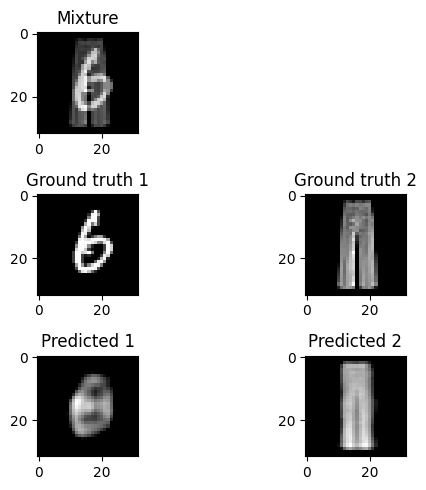

In [ ]:
show_prediction(transfer_model)

As we can observe, the image reconstructions are very bad. This is because we compress the image to a very low resolution and we are not able to reconstruct it back properly. In order to keep the initial structure of the input image we need to include the information of the structure before the compression is performed, and we will do this by skip connections and U-Net architecture.

# A Better Approach: The U-Net

The U-Net structure is made by a downsampling path which process the input image leading to a latent space, and by an upsampling path that reconstruct the image starting from the point in the latent space. There are skip connections between the same level of the downsampling path and the upsampling path in order to keep the spatial and structural informations of the input image by concatenating them to the current reconstruction. <br>
In blind source separation:

*   The **encoder** captures hierarchical features (textures, edges, and high-level representations).

*   The **decoder** reconstructs the two separated sources while maintaining spatial consistency.


In [ ]:
def down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='swish'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

In [ ]:
def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='swish'):
    up = UpSampling2D(size=(2, 2))(inputs)
    concat = Concatenate()([up, skip])
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv

In [ ]:
def unet(img_size):
    inputs = Input(shape=img_size)

    #Down Blocks
    conv1, pool1 = down_block(inputs, 64)
    conv2, pool2 = down_block(pool1, 128)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='swish', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='swish', padding='same')(conv3)

    #Up Blocks
    conv4 = up_block(conv3, conv2, 128)
    conv5 = up_block(conv4, conv1, 64)

    output1 = Conv2D(1, 1, activation="sigmoid", padding="same")(conv5)
    output2 = Conv2D(1, 1, activation="sigmoid", padding="same")(conv5)

    model = Model(inputs=inputs, outputs=[output1, output2], name="unet")
    return model

In [ ]:
unet_model = unet(img_size=(mnist_x_train.shape[1], mnist_x_train.shape[2],1))
unet_model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 32, 32, 64)     │            640 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 8, 8, 256)      │        590,080 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_7           │ (None, 16, 16, 256)    │              0 │ conv2d_20[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 16, 16, 384)    │              0 │ up_sampling2d_7[0][0], │
│ (Concatenate)             │                        │                │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 16, 16, 128)    │        442,496 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_8           │ (None, 32, 32, 128)    │              0 │ conv2d_22[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 32, 32, 192)    │              0 │ up_sampling2d_8[0][0], │
│ (Concatenate)             │                        │                │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 64)     │        110,656 │ concatenate_3[0][0]    │
├──────────────────────

 Total params: 1,882,050 (7.18 MB)

 Trainable params: 1,882,050 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unet_model.compile(
    optimizer = AdamW(lr),
    loss = ['mse','mse']
)

unet_hist = unet_model.fit(
    train_gen,
    epochs = epochs,
    validation_data = validation_gen,
    steps_per_epoch = steps_per_epoch,
    validation_steps = steps_per_epoch
)

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - conv2d_25_loss: 0.0572 - conv2d_26_loss: 0.1526 - loss: 0.2097 - val_conv2d_25_loss: 0.0247 - val_conv2d_26_loss: 0.0355 - val_loss: 0.0602
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - conv2d_25_loss: 0.0220 - conv2d_26_loss: 0.0334 - loss: 0.0553 - val_conv2d_25_loss: 0.0166 - val_conv2d_26_loss: 0.0269 - val_loss: 0.0435
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - conv2d_25_loss: 0.0160 - conv2d_26_loss: 0.0245 - loss: 0.0405 - val_conv2d_25_loss: 0.0133 - val_conv2d_26_loss: 0.0195 - val_loss: 0.0328
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - conv2d_25_loss: 0.0128 - conv2d_26_loss: 0.0182 - loss: 0.0310 - val_conv2d_25_loss: 0.0119 - val_conv2d_26_loss: 0.0161 - val_loss: 0.0280
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - conv2d_25_loss: 0.0109 - conv2d_26_loss: 0.0152 - loss: 0.0261 - val_conv2d_25_loss: 0.0098 - val_conv2d_26_loss: 0.0135 - val_loss: 0.0233
Epoch 6/500
100/10

In [ ]:
unet_model.save_weights("unet_weights.weights.h5")

In [ ]:
compute_statistics(unet_model, test_gen)

mse =  0.000894605927169323
standard deviation =  4.082971128491589e-05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


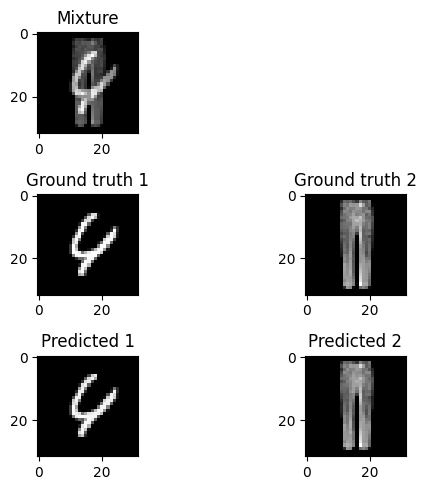

In [ ]:
show_prediction(unet_model)

The results are much better! Even if we get very good results, lets see if we can decrease the mse even more.

# A Deeper U-Net

We add just another down block (2 convolutions) and another up block (another 2 convolutions and an upsampling) and we increase the channel dimension even more w.r.t. the previous network. This will probably be useless since the spatial dimension of the input images is relatively small, but lets check it out what happens.

In [ ]:
def unet2(img_size):
    inputs = Input(shape=img_size)

    #Down Blocks
    conv1, pool1 = down_block(inputs, 64)
    conv2, pool2 = down_block(pool1, 128)
    conv3, pool3 = down_block(pool2, 256)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='swish', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='swish', padding='same')(conv4)

    #Up Blocks
    conv5 = up_block(conv4, conv3, 256)
    conv6 = up_block(conv5, conv2, 128)
    conv7 = up_block(conv6, conv1, 64)

    output1 = Conv2D(1, 1, activation="sigmoid", padding="same")(conv7)
    output2 = Conv2D(1, 1, activation="sigmoid", padding="same")(conv7)

    model = Model(inputs=inputs, outputs=[output1, output2], name="unet2")
    return model

In [ ]:
unet_model2 = unet2(img_size=(mnist_x_train.shape[1], mnist_x_train.shape[2],1))

In [ ]:
unet_model2.summary()

Model: "unet2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 32, 32, 64)     │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 64)     │              0 │ conv2d_28[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 8, 8, 128)      │              0 │ conv2d_30[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 8, 8, 256)      │        590,080 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 4, 4, 256)      │              0 │ conv2d_32[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 4, 4, 512)      │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 4, 4, 512)      │      2,359,808 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_9           │ (None, 8, 8, 512)      │              0 │ conv2d_34[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 8, 8, 768)      │              0 │ up_sampling2d_9[0][0], │
│ (Concatenate)             │                        │                │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 8, 8, 256)      │      1,769,728 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 8, 8, 256)      │        590,080 │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_10     

 Total params: 7,781,826 (29.69 MB)

 Trainable params: 7,781,826 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unet_model2.compile(
    optimizer = AdamW(lr),
    loss = ['mse','mse']
)

unet2_hist = unet_model2.fit(
    train_gen,
    epochs = epochs,
    validation_data = validation_gen,
    steps_per_epoch = steps_per_epoch,
    validation_steps = steps_per_epoch//2
)

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - conv2d_41_loss: 0.0654 - conv2d_42_loss: 0.0806 - loss: 0.1459 - val_conv2d_41_loss: 0.0333 - val_conv2d_42_loss: 0.0344 - val_loss: 0.0677
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - conv2d_41_loss: 0.0264 - conv2d_42_loss: 0.0330 - loss: 0.0594 - val_conv2d_41_loss: 0.0159 - val_conv2d_42_loss: 0.0258 - val_loss: 0.0417
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - conv2d_41_loss: 0.0153 - conv2d_42_loss: 0.0237 - loss: 0.0390 - val_conv2d_41_loss: 0.0132 - val_conv2d_42_loss: 0.0189 - val_loss: 0.0321
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - conv2d_41_loss: 0.0131 - conv2d_42_loss: 0.0181 - loss: 0.0312 - val_conv2d_41_loss: 0.0122 - val_conv2d_42_loss: 0.0157 - val_loss: 0.0279
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - conv2d_41_loss: 0.0118 - conv2d_42_loss: 0.0151 - loss: 0.0269 - val_conv2d_41_loss: 0.0106 - val_conv2d_42_loss: 0.0128 - val_loss: 0.0234
Epoch 6/500
100/1

In [ ]:
unet_model2.save_weights("unet2_weights.weights.h5")

In [ ]:
compute_statistics(unet_model2, test_gen)

mse =  0.0007507044429075904
standard deviation =  2.24041478690354e-05


The results are slightly better than before, in particular we get 1.5e-4 of mse improvement. Can we do even better? During training we observed a stationary trend at some points, which slows down the learning and seems to get stuck in some plateau. Does residual connections help to navigate these flat surfaces?

# An Even Better Approach: U-Net with Residual Connections

In this section we use the idea behind ResNet (i.e. residual blocks). The U-Net structure allows the high level informations (i.e. activations) to flow horizontally from the left down pathway to the right up pathway, and with residual blocks we let the input information at each block to flow vertically improving convergence and preventing degradation.

In [ ]:
def residual_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='swish'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)

    # Residual connection (skip connection)
    z = Conv2D(filters, (1, 1), padding='same')(inputs)
    x = Add()([x, z])  # Element-wise sum
    x = Activation(activation)(x)

    return x

def residual_down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='swish'):
    conv = residual_block(inputs, filters, kernel_size, padding, activation)

    # Use a strided convolution instead of MaxPooling
    pool = Conv2D(filters, kernel_size, strides=(2, 2), activation='swish', padding=padding)(conv)
    return conv, pool

def residual_up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='swish'):
    up = UpSampling2D(size=(2, 2))(inputs)
    concat = Concatenate()([up, skip])
    return residual_block(concat, filters, kernel_size, padding, activation)

def res_unet(img_size):
    inputs = Input(shape=img_size)

    #Down Blocks
    conv1, pool1 = residual_down_block(inputs, 64)
    conv2, pool2 = residual_down_block(pool1, 128)

    # Bottleneck
    conv3 = residual_block(pool2, 256, (3,3), padding='same', activation='swish')

    #Up Blocks
    conv4 = residual_up_block(conv3, conv2, 128)
    conv5 = residual_up_block(conv4, conv1, 64)

    output1 = Conv2D(1, 1, activation="sigmoid", padding="same")(conv5)
    output2 = Conv2D(1, 1, activation="sigmoid", padding="same")(conv5)

    model = Model(inputs=inputs, outputs=[output1, output2], name="unet2")
    return model

In [ ]:
resunet_model = res_unet(img_size=(mnist_x_train.shape[1], mnist_x_train.shape[2],1))
resunet_model.summary()

Model: "unet2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │          8,320 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
│                      

 Total params: 2,174,786 (8.30 MB)

 Trainable params: 2,172,226 (8.29 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
resunet_model.compile(
    optimizer = AdamW(lr),
    loss = ['mse','mse']
)

resunet_hist = resunet_model.fit(
    train_gen,
    epochs = epochs,
    validation_data = validation_gen,
    steps_per_epoch = steps_per_epoch,
    validation_steps = steps_per_epoch // 4
)

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - conv2d_17_loss: 0.0571 - conv2d_18_loss: 0.0447 - loss: 0.1018 - val_conv2d_17_loss: 0.0749 - val_conv2d_18_loss: 0.0949 - val_loss: 0.1699
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - conv2d_17_loss: 0.0063 - conv2d_18_loss: 0.0088 - loss: 0.0151 - val_conv2d_17_loss: 0.0774 - val_conv2d_18_loss: 0.0694 - val_loss: 0.1468
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - conv2d_17_loss: 0.0046 - conv2d_18_loss: 0.0061 - loss: 0.0107 - val_conv2d_17_loss: 0.0575 - val_conv2d_18_loss: 0.0576 - val_loss: 0.1151
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - conv2d_17_loss: 0.0038 - conv2d_18_loss: 0.0051 - loss: 0.0089 - val_conv2d_17_loss: 0.0418 - val_conv2d_18_loss: 0.0411 - val_loss: 0.0829
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - conv2d_17_loss: 0.0035 - conv2d_18_loss: 0.0045 - loss: 0.0080 - val_conv2d_17_loss: 0.0176 - val_conv2d_18_loss: 0.0325 - val_loss: 0.0501
Epoch 6/500
100

In [ ]:
resunet_model.save_weights("resunet_weights.weights.h5")

In [ ]:
compute_statistics(resunet_model, test_gen)

mse =  0.0006758718722267076
standard deviation =  1.9455859294144462e-05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


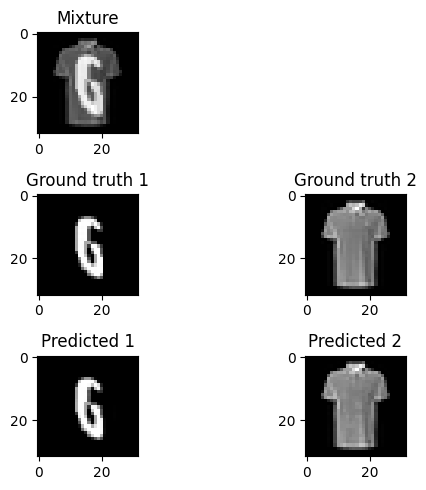

In [ ]:
show_prediction(resunet_model)

The mse improved by almost 3e-4 w.r.t. the first U-Net model we tried. Now let check visually what happens to the loss curves (same as the evaluation metric in this case).

# Results Comparison

Since there are no signs of overfitting in the training logs, we focus on the validation results and don't consider the training ones.

In [ ]:
def plot_loss(start):
  epochs_range2 = np.arange(start, epochs, 1)

  plt.figure(figsize=(7,5))
  plt.title('Validation Loss')
  plt.plot(epochs_range2, unet_hist['val_loss'][start:], label='U-Net')
  plt.plot(epochs_range2, unet2_hist['val_loss'][start:], label='Deeper U-Net')
  plt.plot(epochs_range2, resunet_hist.history['val_loss'][start:], label='Resnet-U-Net')

  plt.legend()
  plt.show()

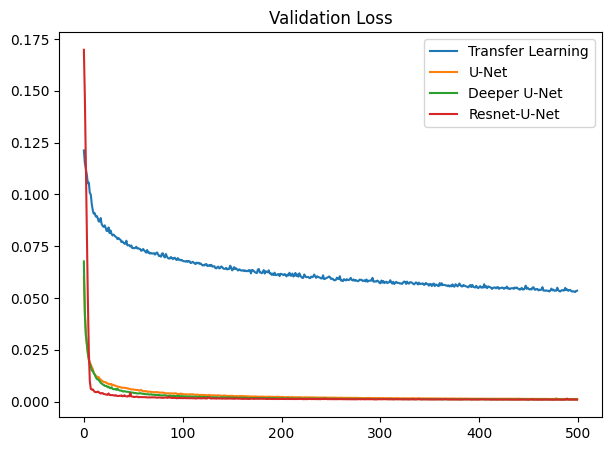

In [ ]:
epochs_range = np.arange(0, epochs, 1)

plt.figure(figsize=(7,5))
plt.title('Validation Loss')
plt.plot(epochs_range, transfer_hist['val_loss'], label='Transfer Learning')
plt.plot(epochs_range, unet_hist['val_loss'], label='U-Net')
plt.plot(epochs_range, unet2_hist['val_loss'], label='Deeper U-Net')
plt.plot(epochs_range, resunet_hist.history['val_loss'], label='Resnet-U-Net')

plt.legend()
plt.show()

As we can see, the transfer learning method is completely out of the game. I implemented that architecture just to show how big is the contribute of skip connections to the task. <br> Now we can exclude that loss from the graph and zoom at the interesting part of the plots while noticing how fast is the convergence of the mixed ResNet/U-Net model with respect to the other U-Net versions (thanks to the residual connections and maybe the batch normalization).

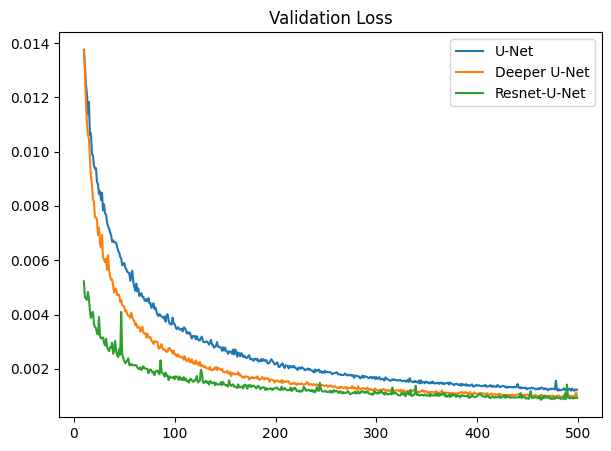

In [ ]:
plot_loss(10)

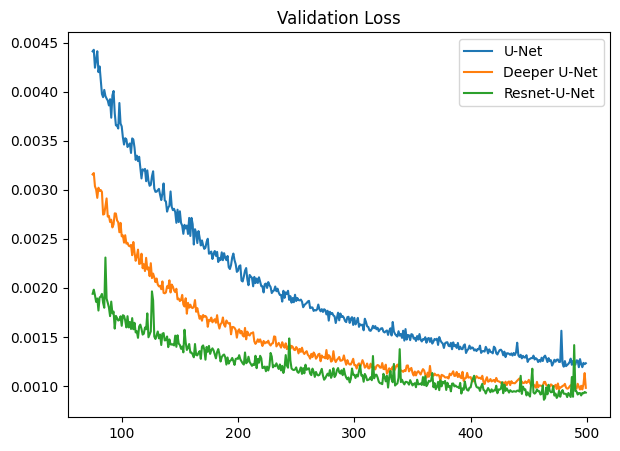

In [ ]:
plot_loss(75)

This last plot shows that a deeper U-Net is a good idea in this case, and we could make the network even deeper in order to check out wether there is a further improvement or not. <br> Moreover, the combination with ResNet speeds up the convergence as the green line shows (even if the training is a little more unstable), thus, it is definitely the best model found in order to solve this task since it leads to very good visual results too during the prediction (see more about this in the next section).

# Showing Some Predictions

#################### PREDICTION 1 ####################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


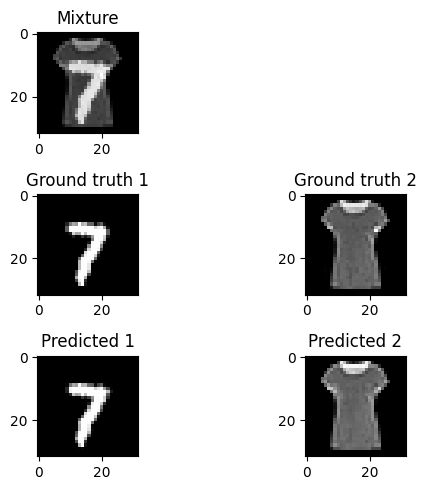

#################### PREDICTION 2 ####################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


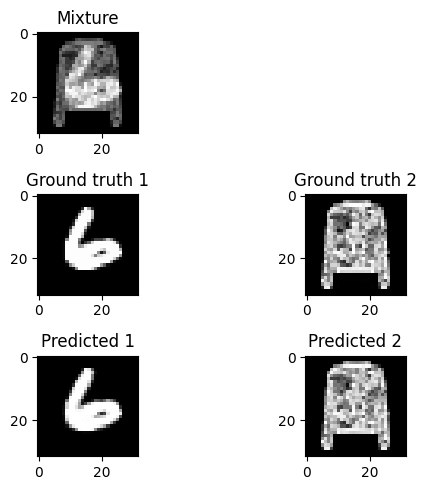

#################### PREDICTION 3 ####################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


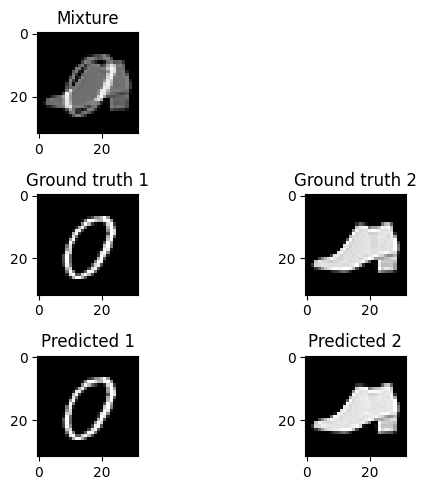

#################### PREDICTION 4 ####################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


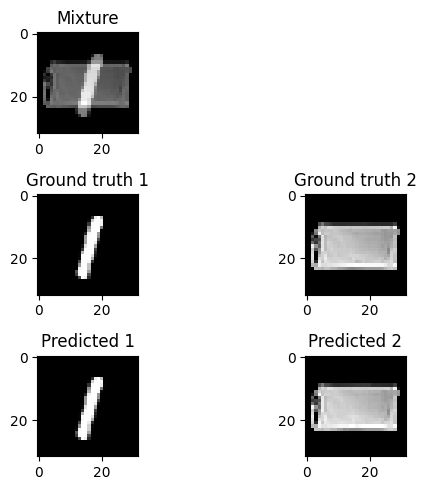

#################### PREDICTION 5 ####################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


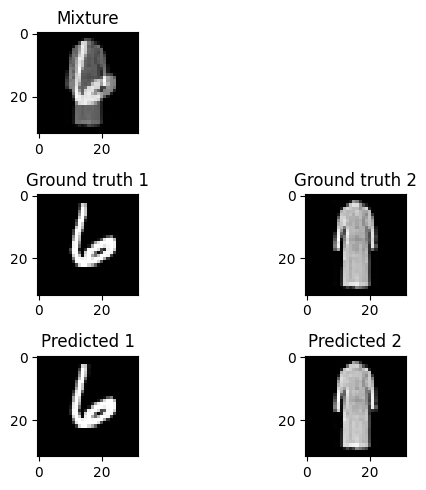

#################### PREDICTION 6 ####################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


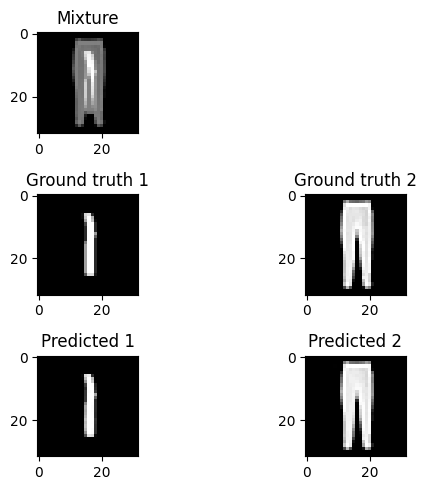

#################### PREDICTION 7 ####################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


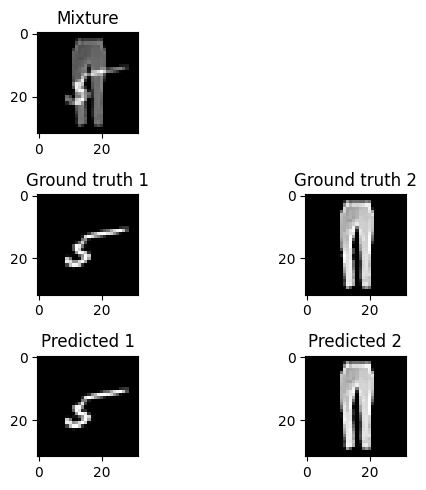

#################### PREDICTION 8 ####################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


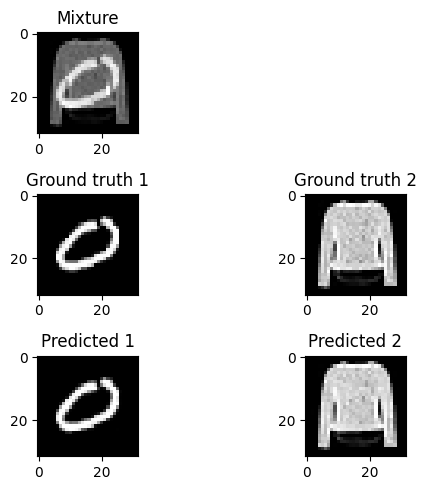

#################### PREDICTION 9 ####################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


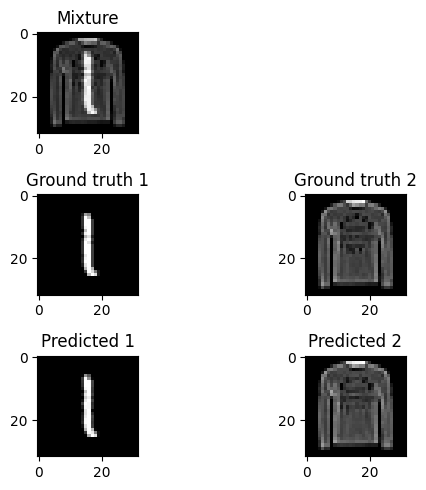

In [ ]:
for i in range(1,10):
  print(f"#################### PREDICTION {i} ####################")
  show_prediction(resunet_model)